In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization as BN, ReLU, MaxPool2D, Flatten, Dense
from tensorflow.keras.layers import Bidirectional, LSTM, Embedding, Reshape
from tensorflow.keras import Input
from tensorflow.keras import Model
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from librosa import istft
from librosa.output import write_wav
from librosa import griffinlim
import librosa.display
from denoiser import reduce_noise_power as denoise, enhance
from MyCallback import MyCallback
%matplotlib inline

In [2]:
x = "D:/Documents/Liclipse Workspace/Accent_Style_Transfer_Project_version_1/output/audio/good_ones/Recording_100_1_0.002_girl52.wav"
y1, sr = librosa.load(x)
display(Audio(y1,rate=sr))

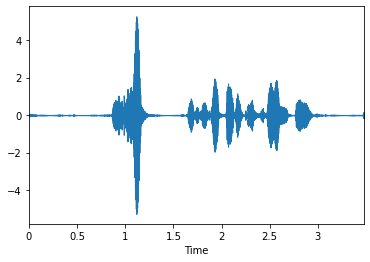

In [3]:
librosa.display.waveplot(y1,sr=sr, x_axis='time');

In [2]:
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, n_fft)
    p = np.angle(S)
    return np.log1p(np.abs(S[np.newaxis,:,:430])), fs

In [3]:
CONTENT_FILENAME = 'Audio_data_Wav/us_english/abacus.wav'
STYLE_FILENAME = 'Audio_data_Wav/indian_english/abacus.wav'
n_fft = 512

In [4]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [5]:
# Read both style and content
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

In [6]:
print(a_content.shape)
N_SAMPLES = a_content.shape[2]
N_CHANNELS = a_content.shape[1]
a_style = a_style[:, :N_CHANNELS, :N_SAMPLES]

(1, 257, 118)


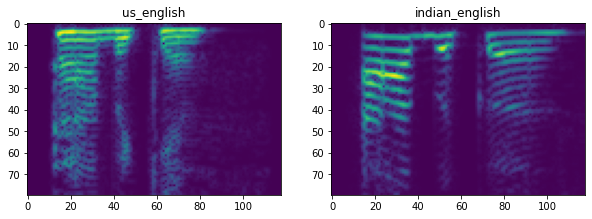

In [7]:
# Display the spectograms

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('us_english')
plt.imshow(a_content[0,:80,:])
plt.subplot(1, 2, 2)
plt.title('indian_english')
plt.imshow(a_style[0,:80,:])
plt.show()

## Define Net

In [8]:
N_FILTERS = 3
inputs = Input((1,N_CHANNELS,N_SAMPLES))
# print(inputs.shape)
hl = Conv2D(N_FILTERS, 3, strides=2, activation='relu', padding='same')(inputs)
# print(hl.shape)
hl = BN()(hl)
hl = ReLU()(hl)

hl = Conv2D(N_FILTERS, 3, strides=2, activation='relu', padding='same')(hl)
hl = BN()(hl)
hl = ReLU()(hl)
# print(hl.shape)
hl = MaxPool2D()(hl)
# print(hl.shape)
# hl = Flatten()(hl)
# print(hl.shape)
hl = Reshape((hl.shape[1]*hl.shape[2],hl.shape[3]))(hl)
# print(hl.shape)
op = Dense(1024, activation='relu')(hl)
# print(op.shape)
tf.keras.backend.set_image_data_format('channels_last')
hl = Bidirectional(LSTM(128, return_sequences=True))(op)
hl = Bidirectional(LSTM(128, return_sequences=True))(hl)
hl = Bidirectional(LSTM(128, return_sequences=True))(hl)
hl = Flatten()(hl)
hl = Dense(1024, activation='relu')(hl)
outputs = Dense(N_CHANNELS * N_SAMPLES,activation = 'relu')(hl)
outputs = Reshape((1, N_CHANNELS , N_SAMPLES))(outputs)

In [9]:
model = Model(inputs = inputs, outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
callback = MyCallback(value=0.5)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 257, 118)]     0         
                                                                 
 conv2d (Conv2D)             (None, 3, 129, 59)        30        
                                                                 
 batch_normalization (BatchN  (None, 3, 129, 59)       236       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 3, 129, 59)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 65, 30)         84        
                                                                 
 batch_normalization_1 (Batc  (None, 3, 65, 30)        120       
 hNormalization)                                             

In [10]:
num_epochs = 500
a_content_tf = np.ascontiguousarray(a_content[None,:,:])
a_style_tf = np.ascontiguousarray(a_style[None,:,:])
history = model.fit(a_content_tf, a_style_tf, epochs=num_epochs, callbacks=[callback], verbose=0)

prediction = model.predict(a_content_tf)
# print(prediction.shape)
# print(type(prediction))
# print(prediction)
np.save('prediction.npy',prediction, allow_pickle=True)

Model training stopped as "accuracy" reached value = 0.5


In [11]:
sr = 22050
prediction = np.load('prediction.npy', allow_pickle=1)[0][0]
print(prediction.shape)

(257, 118)


In [12]:
x = griffinlim(prediction, n_iter=1000)

write_wav(f'output/prediction_{n_fft}.wav', x, sr)

y, sr = librosa.load(f'output/prediction_{n_fft}.wav')

y = denoise(y, sr)

y = enhance(y)
OUTPUT_FILENAME = f'output/prediction_{n_fft}_cleaned.wav'
write_wav(f'output/prediction_{n_fft}_cleaned.wav', y, sr)

In [13]:
display(Audio(OUTPUT_FILENAME))

In [14]:
merged,_ = read_audio_spectum(OUTPUT_FILENAME)

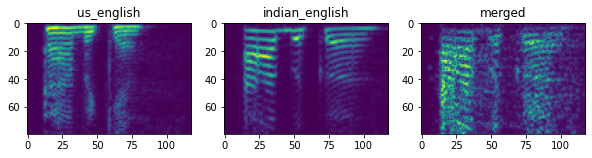

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('us_english')
plt.imshow(a_content[0,:80,:])
plt.subplot(1, 3, 2)
plt.title('indian_english')
plt.imshow(a_style[0,:80,:])
plt.subplot(1, 3, 3)
plt.title('merged')
plt.imshow(merged[0,:80,:])
plt.show()